In [203]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
import matplotlib.pyplot as plt
import corner, os, glob, json
import numpy as np
import pandas as pd
import astropy.units as u
from enterprise.signals import utils
%matplotlib inline

# Directories

In [205]:
#Reference directory
topdir = os.getcwd()

In [206]:
datadir_V4 = topdir + '/SimInject4/SimRuns'

#Two GWB powerlaws
run_1_dir = datadir_V4 + '/simGWB_1'
run_2_dir = datadir_V4 + '/simGWB_2'

In [207]:
#only 1 gwb rund
run_3_dir = datadir_V4 + '/simGWB_only1gwb_1'
run_4_dir = datadir_V4 + '/simGWB_only1gwb_2'

# Load Chains

In [208]:
#Load chains for run 1
chain_run_1 = pd.read_csv(run_1_dir + '/chain_1.txt', sep='\t', dtype=float, header=None).values
burn_run_1 = int(0.25 * chain_run_1.shape[0])

In [209]:
#Load chains for run 2
chain_run_2 = pd.read_csv(run_2_dir + '/chain_1.txt', sep='\t', dtype=float, header=None).values
burn_run_2 = int(0.25 * chain_run_2.shape[0])

In [210]:
#Load chains for run 3
chain_run_3 = pd.read_csv(run_3_dir + '/chain_1.txt', sep='\t', dtype=float, header=None).values
burn_run_3 = int(0.25 * chain_run_3.shape[0])

In [211]:
#Load chains for run 4
chain_run_4 = pd.read_csv(run_4_dir + '/chain_1.txt', sep='\t', dtype=float, header=None).values
burn_run_4 = int(0.25 * chain_run_4.shape[0])

# Load Parameter Files

In [212]:
#Load param files to iterate through pulsars in pta
with open(run_1_dir + '/parameters.json') as pf:
    param_dict_run_1 = json.load(pf)
    pf.close()

In [213]:
#Load param files to iterate through pulsars in pta
with open(run_2_dir + '/parameters.json') as pf:
    param_dict_run_2 = json.load(pf)
    pf.close()

In [214]:
#Load param files to iterate through pulsars in pta
with open(run_3_dir + '/parameters.json') as pf:
    param_dict_run_3 = json.load(pf)
    pf.close()

In [215]:
#Load param files to iterate through pulsars in pta
with open(run_4_dir + '/parameters.json') as pf:
    param_dict_run_4 = json.load(pf)
    pf.close()

# Plot injections and get truth values

In [216]:
background_amp_1 = 1.3e-15
background_amp_2 = 1.0e-15
background_amp_3 = 5.0e-15

background_gamma_1 = 13./3.
background_gamma_2 = 7./3.
background_gamma_3 = 7./3.

print(np.log10(background_amp_1))
print(np.log10(background_amp_2))
print(np.log10(background_amp_3))

truths_1 = [np.log10(background_amp_1),np.log10(background_amp_2)]
truths_2 = [np.log10(background_amp_1),np.log10(background_amp_3)]
truths_3 = [np.log10(background_amp_1)]
truths_4 = [np.log10(backgournd_amp_3)]

-14.886056647693163
-15.0
-14.301029995663981


In [217]:
def Plaw(f, log10_A, gamma, components=1):
    #From enterprise
    f = f*u.Hz
    df = np.diff(np.concatenate((np.array([0])*u.Hz, f[::components])))
    df[0] = df[1]

    fyr = 1/u.yr.to('s')*u.Hz
    return ((10**log10_A)**2 / 12.0 / np.pi**2 * fyr**(gamma-3) * f**(-gamma) * np.repeat(df, components))

In [218]:
howml = 10
Tspan = 15*u.yr.to('s')*u.s
cadence = 14*u.d.to('s')*u.s
print(1/(2*cadence))
print(1/(howml*Tspan))

f = np.arange(0,1/(2*cadence.value),1/(howml*Tspan.value))
f = f[1:]
h_1 = Plaw(f,np.log10(background_amp_1),gamma=background_gamma_1)
h_2 = Plaw(f,np.log10(background_amp_2),gamma=background_gamma_2)
h_3 = Plaw(f,np.log10(background_amp_3),gamma=background_gamma_3)

intersect_1 = (background_amp_1/background_amp_2)/u.yr.to('s')*u.s
intersect_2 = (background_amp_1/background_amp_3)/u.yr.to('s')*u.s

4.133597883597884e-07 1 / s
2.1125391876019301e-10 1 / s


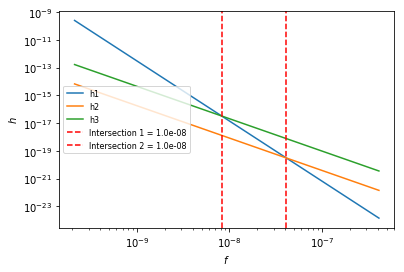

In [219]:
plt.figure()
plt.loglog(f,h_1,label='h1')
plt.loglog(f,h_2,label='h2')
plt.loglog(f,h_3,label='h3')
plt.axvline(x=intersect_1.value,color='r',linestyle='--',label='Intersection 1 = %.1e' %intersect.value)
plt.axvline(x=intersect_2.value,color='r',linestyle='--',label='Intersection 2 = %.1e' %intersect.value)
plt.legend(loc='center left',fontsize = 8)
plt.ylabel(r'$h$')
plt.xlabel(r'$f$')
plt.show()

# Plot Histograms

In [220]:
#display all histograms for particular parameter (ie. red_noise_log10_A)
def draw_histograms(data, labels, indices,figsize=(10,5),n_cols=2,truths=None):
    #Takes in data (chain, already burned), labels (parameters), and indices of parameters we want to look at
    n_rows = int(len(indices)/n_cols)
    n_bins = 30
    fig,axarr =plt.subplots(nrows=n_rows,ncols=n_cols,figsize=figsize)
    ii = 0
    if n_rows == 1:
        if n_cols == 1:
            axarr.hist(data[:,indices[ii]],bins=n_bins, density=True,histtype = 'step')
            axarr.axvline(x=truths)
        else:
            for j in range(n_cols):
                axarr[j].hist(data[:,indices[ii]],bins=n_bins, density=True,histtype = 'step')
                axarr[j].set_xlabel(labels[indices[ii]])
                ii += 1
    else:    
        for i in range(n_rows):
            for j in range(n_cols):
                axarr[i][j].hist(data[:,indices[ii]],bins=n_bins, density=True,histtype = 'step')
                axarr[i][j].set_xlabel(labels[indices[ii]])
                ii += 1
    fig.tight_layout()
    plt.show()

In [221]:
indices_1 = [len(param_dict_run_1)-2, len(param_dict_run_1)-1]
indices_2 = [len(param_dict_run_2)-2, len(param_dict_run_2)-1]
indices_3 = [len(param_dict_run_3)-1]
indices_4 = [len(param_dict_run_4)-1]

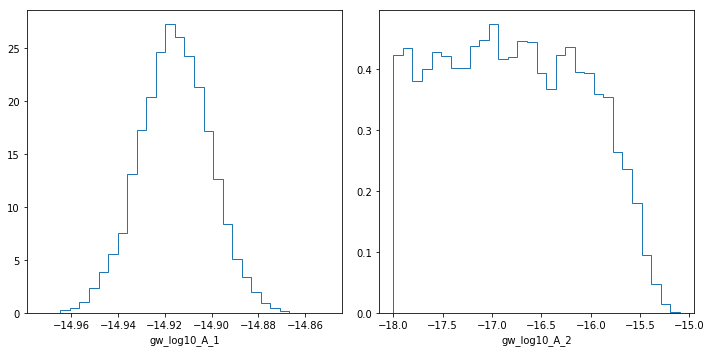

In [222]:
draw_histograms(chain_run_1[burn_run_1:],param_dict_run_1,indices_1)

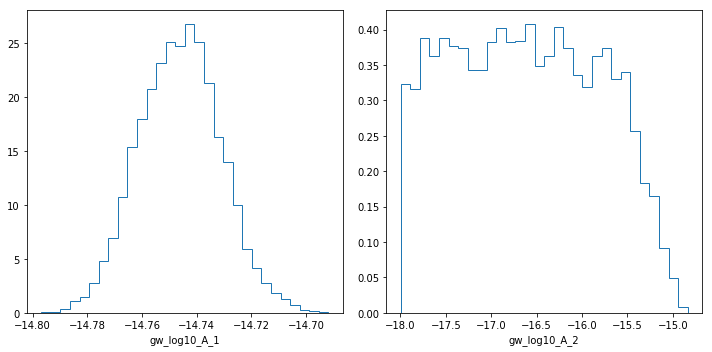

In [223]:
draw_histograms(chain_run_2[burn_run_2:],param_dict_run_2,indices_2)

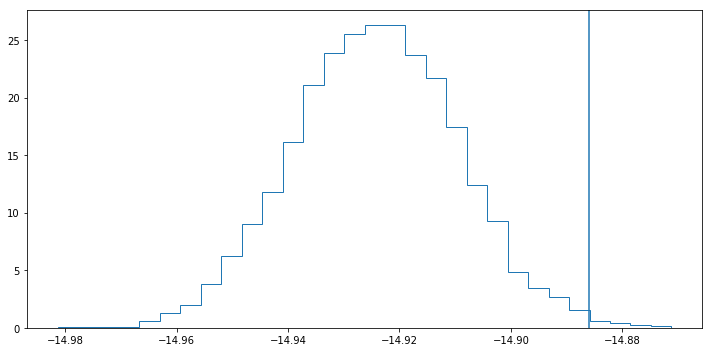

In [224]:
draw_histograms(chain_run_3[burn_run_3:],param_dict_run_3,indices_3,n_cols=1,truths=truths_3[0])

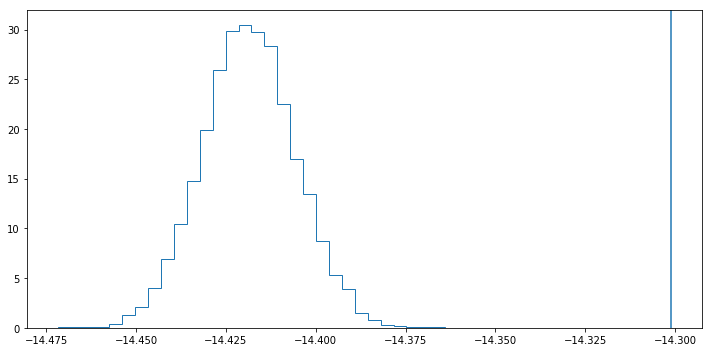

In [225]:
draw_histograms(chain_run_4[burn_run_4:],param_dict_run_4,indices_4,n_cols=1,truths=truths_4[0])

In [226]:
pulsar_indices_1 = range(0,len(param_dict_run_1)-2)
pulsar_indices_1 = []
for i,param in enumerate(param_dict_run_1):
    if 'red' in param.strip('_'):
        pulsar_indices_1.append(i)

In [227]:
draw_histograms(chain_run_1[burn_run_1:],param_dict_run_1,pulsar_indices_1,figsize=(10,55))

<Figure size 720x3960 with 0 Axes>

# Trace Plots

In [228]:
#display all histograms for particular parameter (ie. red_noise_log10_A)
def draw_trace(data, labels, indices,n_cols=2):
    #Takes in data (chain, already burned), labels (parameters), and indices of parameters we want to look at
    n_rows = int(len(indices)/n_cols)
    fig,axarr =plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(10,5))
    ii = 0
    if n_rows == 1:
        if n_cols == 1:
            axarr.plot(data[:,indices[ii]])
            axarr.set_ylabel(labels[indices[ii]])
        else:
            for j in range(n_cols):
                axarr[j].plot(data[:,indices[ii]])
                axarr[j].set_ylabel(labels[indices[ii]])
                ii += 1
    else:    
        for i in range(n_rows):
            for j in range(n_cols):
                axarr[i][j].plot(data[:,indices[ii]])
                axarr[i][j].set_ylabel(labels[ii])
                ii += 1
    fig.tight_layout()
    plt.show()

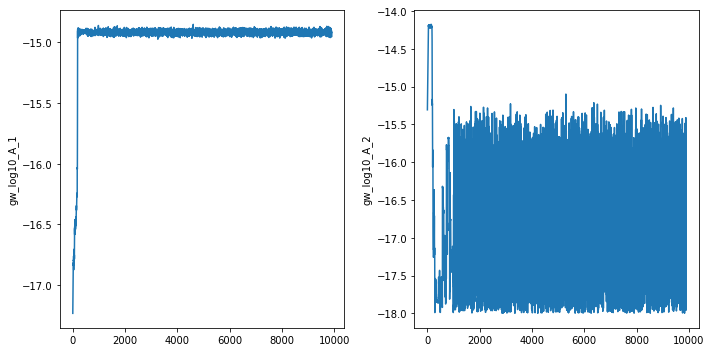

In [229]:
draw_trace(chain_run_1,param_dict_run_1,indices_1)

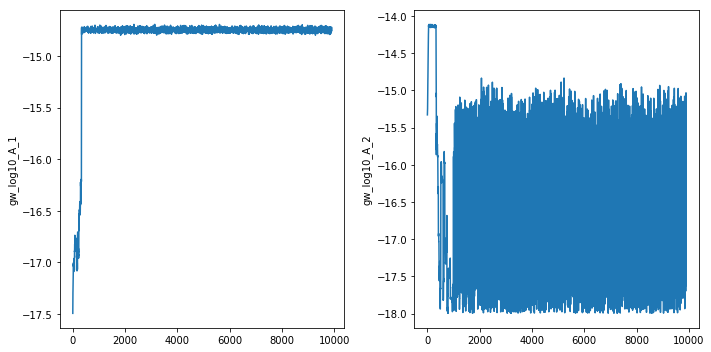

In [230]:
draw_trace(chain_run_2,param_dict_run_2,indices_2)

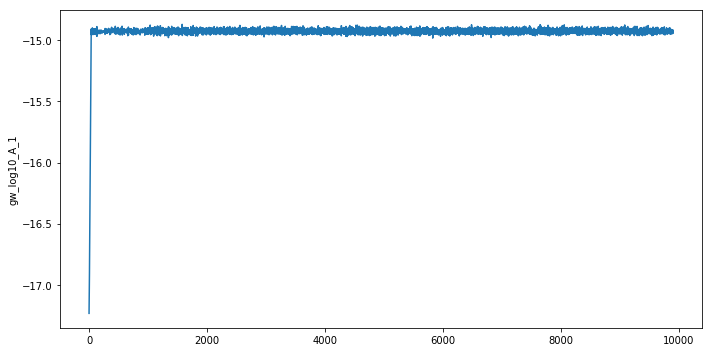

In [231]:
draw_trace(chain_run_3,param_dict_run_3,indices_3,n_cols=1)

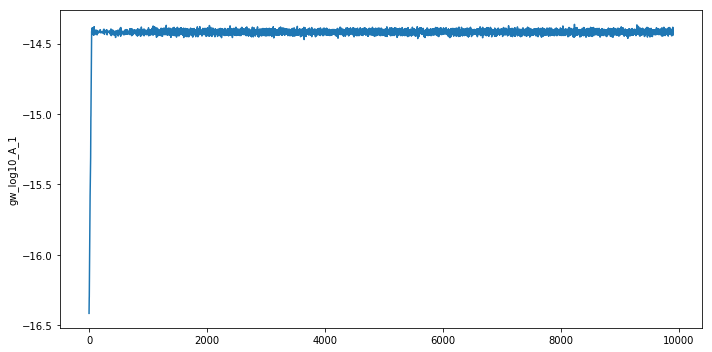

In [232]:
draw_trace(chain_run_4,param_dict_run_4,indices_4,n_cols=1)

In [233]:
def CornerPlots(chain,burn,indices,params,truths):
    param_labels = []
    for index in indices:
        param_labels.append(params[index])
    corner.corner(chain[burn:,indices], bins = 30, labels = param_labels, truths=truths)

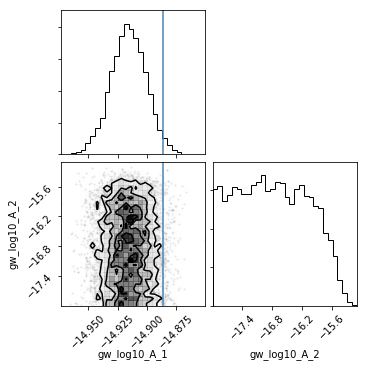

In [234]:
CornerPlots(chain_run_1,burn_run_1,indices_1,param_dict_run_1,truths_1)

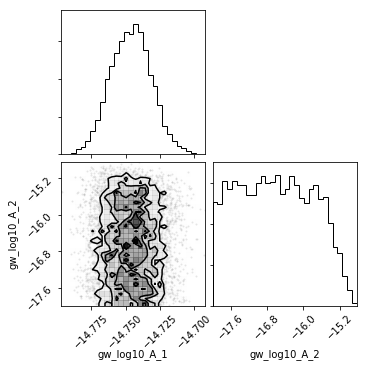

In [235]:
CornerPlots(chain_run_2,burn_run_2,indices_2,param_dict_run_2,truths_2)